## Photonic crystal cavity

In this notebook, we will simulate the commonly used L3 photonic crystal cavity composed of three missing holes in a hexagonal lattice of holes in a silicon slab. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web

Using Tidy3D credentials from stored file


### Coarse simulation

We will first run a broadband simulation to examine the spectrum, and zone in on the fundamental mode of the cavity. We start with defining some general parameters. We will use a fairly low spatial resolution for this initaly simulation. It's worth remembering that the PML extend **beyond** the simulation domain, so we don't need to worry about them covering some of the PhC holes. The one thing we have to remember is to extend the slab through the PML.

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 12

# Lattice constant of the PhC in micron
alattice = 0.4

# Regular PhC lattice parameters
ra = 0.25 * alattice # hole radius
d_slab = 0.22        # slab thickness
n_slab = 3.48        # refractive index of the slab

# Materials - air and silicon
air = td.Medium()
si = td.Medium(permittivity=n_slab**2)

# Mesh step in x, y, z, in micron
dl = 0.04
grid_size = [dl, dl*np.sqrt(3)/2, dl]

# Central frequency around which we'll look for the cavity mode (Hz)
freq0 = 2e14

# Source bandwidth (Hz)
fwidth = 4e13

# Simulation run time (s)
run_time = 20/fwidth

# Simulation domain size (micron)
sim_size = [(Nx+2)*alattice, ((Ny+1)*alattice)*np.sqrt(3)/2, 4]

Next, we define the positions of the holes that make the photonic crystal structure.

In [3]:
# Define x and y positions in one quadrant of the simulation domain
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Remove the first two holes to make the L3 defect
xp = xp[2:]
yp = yp[2:]

# Append holes for the other three quadrants
xf, yf = [], []
for x, y in zip(xp, yp):
    xf += [x, x, -x]
    yf += [y, -y, y]
    if x > 0 and y > 0:
        xf += [-x]
        yf += [-y]

Initialize all structures.

In [4]:
slab = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[td.inf, td.inf, d_slab]), 
    medium=si
)

holes = []
for x, y in zip(xf, yf):
    holes.append(
        td.Structure(
            geometry=td.Cylinder(
                center = (np.array([x, y, 0])*alattice).tolist(),
                axis = 2,
                radius = ra,
                length = d_slab
            ),
            medium = air
        )
    )

Initialize the source. We are looking for the fundamental mode of the L3 cavity, so we use a y-polarized  source at the center of the cavity.

In [5]:
source = td.VolumeSource(
    center=(0, 0, 0),
    size=(0,0,0),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth),
    polarization='Ey')

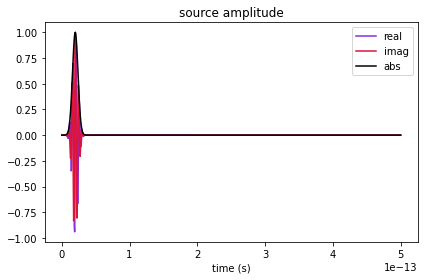

In [6]:
source.source_time.plot(np.linspace(0, run_time, 1001))
plt.show()

Finally, we also place a time monitor in the same location as the source. We set the time monitor starting time to be after the source decay, such that we can exclude the source signature from the recorded spectrum.

In [7]:
t_start = 1e-13
tmonitor = td.FieldTimeMonitor(center=[0, 0, 0], size=[0, 0, 0], start=t_start, name='field')

Initialize the simulation and visualize the structure.

In [8]:
# the structures so close to PML will cause some warnings, let's suppress them  for sake of this notebook.
td.set_logging_level('error')

sim = td.Simulation(
    size=sim_size, 
    grid_size=grid_size, 
    structures=[slab]+holes, 
    sources=[source],
    monitors=[tmonitor],
    run_time=run_time,
    pml_layers=3*[td.PML()])

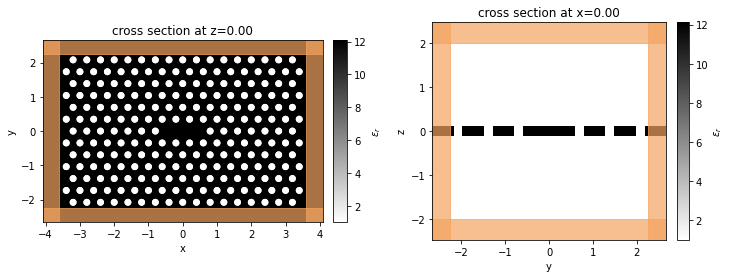

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim.plot_eps(z=0, ax=ax[0]);
sim.plot_eps(x=0, ax=ax[1]);

### Run simulation and examine the spectrum

Now that the simulation is constructed, we can run it using the `web` API of Tidy3D. First, we submit the project.

In [10]:
# Submit a project to the cluster
job = web.Job(simulation=sim, task_name='L3 low res')
job.upload()
job.start()

And we can continuously monitor the status until the run is succsessful.

In [11]:
job.monitor()

Output()

[12:55:05] status = preprocess                                               ]8;id=680368;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=463636;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[12:55:36] status = running                                                  ]8;id=574469;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=758251;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[12:56:09] status = postprocess                                              ]8;id=809663;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=275061;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[12:57:10] status = success                                                  ]8;id=389992;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=622408;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

Once the run is successful, we can download the results and load them in the `td.SimulationData` object.

In [12]:
sim_data = job.load(path='data/sim_data.hdf5')

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

We finally plot the time dependence of the field in the center of the cavity, and the spectrum computed using a Fourier transform of that field. For the latter, we use the in-built `dft_spectrum` function.

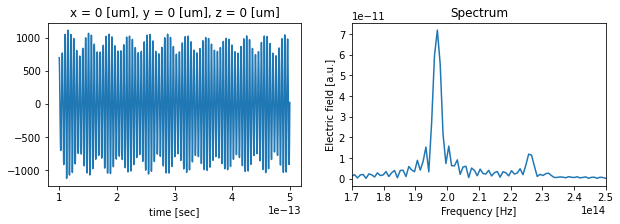

In [13]:
# Get data from the TimeMonitor
tdata = sim_data['field']

time_series = tdata.Ey.interp(x=0, y=0, z=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot time dependence 
time_series.plot(ax=ax1)
# ax[0].set_xlabel("Time [s]")
# ax[0].set_ylabel("Electric field [a.u.]");
# ax[0].set_title("Ey vs. time")

# Make frequency mesh and plot spectrum
dt = sim_data.simulation.dt
fmesh = np.linspace(1.6e14, 2.5e14, 101)

dft_matrix = np.exp(2j * np.pi * fmesh[:, None] * time_series.t.values) / np.sqrt(2 * np.pi)
spectrum = dt * dft_matrix @ np.real(time_series.values)

ax2.plot(fmesh, np.abs(spectrum))
ax2.set_xlim(1.7e14, 2.5e14)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Electric field [a.u.]");
ax2.set_title("Spectrum");

We see a big peak close to `f = 195THz`, which is most likely what we are looking for, because a) the fundamental mode is the longest-lived and b) we use a y-polarized source at the center of the simulation domain, which does not excite some of the other modes.

In [14]:
# New target frequency based on spectrum above
freq0 = 1.95e14

# Narrow-bandwidth source
source = td.VolumeSource(
    size=(0,0,0),
    center=(0, 0, 0),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth/5),
    polarization='Ey')

# Also increase the run time a bit
run_time = 50/fwidth

# 20 pixels per lattice period
dl = 0.02
grid_size = [dl, dl*np.sqrt(3)/2, dl]

We can use both a time and a frequency monitor to obtain the field profile, each coming with advantages and disadvantages. The frequency monitor captures accurately the frequency-domain field, but that includes the source signature. On the other hand, examining the time-domain field can capture the "eigenmode" of the system, but only if all the other modes have decayed. This is, to a very large extent, the case in our simulation, so as we'll see the second approach works very well.

**NB**: An important thing to note is that a 2D time monitor can result in a very large amount of data. Because of this, we will only record the fields near the last time step, setting `start = 0.9 * run_time` in the `FieldTimeMonitor`.

In [15]:
# Time and frequency monitors
tmonitor = td.FieldTimeMonitor(
    center=[0, 0, 0],
    size=[4, 2*np.sqrt(3), 0],
    start=run_time*0.9,
    name='final_time')

fmonitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[4, 2*np.sqrt(3), 0],
    freqs=[freq0],
    name='field')

Finally, we initialize the simulation.

In [16]:
# Initialize simulation
sim = td.Simulation(
    size=sim_size, 
    grid_size=grid_size, 
    structures=[slab]+holes, 
    sources=[source], 
    monitors=[tmonitor, fmonitor],
    run_time=run_time,
    pml_layers=3*[td.PML()],
)

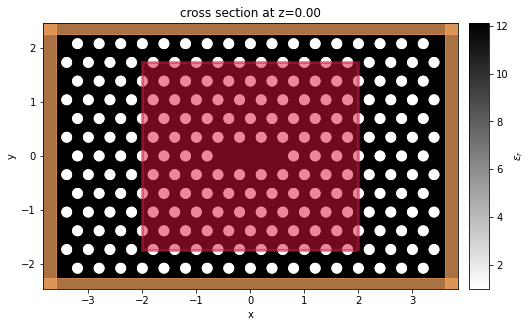

In [17]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sim.plot_eps(z=0, ax=ax);

We run the simulation as above.

In [18]:
sim_data = web.run(sim, task_name='L3 high res', path='data/sim_data.hdf5')

Output()

[12:57:18] status = queued                                                      ]8;id=276370;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=321525;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[12:57:32] status = preprocess                                                  ]8;id=991896;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=831733;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[12:57:57] status = running                                                     ]8;id=766423;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=921684;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[13:04:48] status = visualize                                                   ]8;id=753870;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=896091;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[13:05:21] status = success                                                     ]8;id=397906;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=503154;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

Output()

Downloading... ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:25:51

KeyboardInterrupt: 

Finally, we plot the field recorded by the frequency monitor, with a rescaled colorbar in order to suppress the strongly dominant feature of the source in the center. On the other hand, the field stored in the time monitor reveals the eigenmode of the cavity.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# sim_data.plot_field('final_time', 'Ex', val='abs', z=0, time=run_time, ax=ax[0])
sim_data.plot_field('field', 'Ex', val='abs', freq=freq0, ax=ax[1]);

In [ ]:
sim_data['final_time'].data_dict['Ex'].values.shape